# Auto-segmentation Inference & Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AustralianCancerDataNetwork/pydicer/blob/main/examples/AutoSegmentation.ipynb)

A common task when working the medical imaging data, it to run an auto-segmentation model
(inference) on the images in your dataset. If you have manual definitions of the same structures
available in your dataset, you will typically want to compare the auto and the manual
segmentations, computing metrics and produce plots and visualisation.

This example notebook will guide you through the process of performing model inference and analysis
of those structures. We will use a single atlas-based segmentation model for demonstration
purposes.

> Warning: The auto-segmentation results produced by the example in this notebook are poor. The
> atlas based segmentation function is optimised for runtime is purely provided to demonstrate how
> to run and analyse an auto-segmentation model.

In [1]:
try:
    from pydicer import PyDicer
except ImportError:
    !pip install pydicer
    from pydicer import PyDicer

import os
import logging

from pathlib import Path

import SimpleITK as sitk

from platipy.imaging.registration.utils import apply_transform
from platipy.imaging.registration.linear import linear_registration
from platipy.imaging.registration.deformable import fast_symmetric_forces_demons_registration

from pydicer.utils import fetch_converted_test_data

from pydicer.generate.segmentation import segment_image, read_all_segmentation_logs

from pydicer.analyse.compare import (
    compute_contour_similarity_metrics,
    get_all_similarity_metrics_for_dataset,
    prepare_similarity_metric_analysis
)


## Setup PyDicer

For this example, we will use the LCTSC test data which has already been converted using PyDicer.
We also initialise our PyDicer object.

In [2]:
working_directory = fetch_converted_test_data("./lctsc_autoseg", dataset="LCTSC")
pydicer = PyDicer(working_directory)

## Prepare Atlas

Since we will use a single atlas-based segmentation model, we must split our data, selecting one
case as our `atlas` and the remaining cases as the `validation` set. We use the PyDicer [dataset preparation module](https://australiancancerdatanetwork.github.io/pydicer/_examples/DatasetPreparation.html) to create these subsets of data.

In [3]:
df = pydicer.read_converted_data()

# Specify the patient ID to use as the atlas case
atlas_dataset = "atlas"
atlas_case  = "LCTSC-Train-S1-001"
df_atlas = df[df.patient_id==atlas_case]

# And the remaining cases will make up our validation set
validation_dataset = "validation"
df_validation = df[df.patient_id!=atlas_case]

# Use the dataset preparation module to prepare these two data subsets
pydicer.dataset.prepare_from_dataframe(atlas_dataset, df_atlas)
pydicer.dataset.prepare_from_dataframe(validation_dataset, df_validation)

## Define Segmentation Function

Now that our `atlas` and `validation` sets are ready, we will define our function which will run
our simple single atlas-based auto-segmentation model for us. This example uses the [atlas-based
segmentation tools available in PlatiPy](https://pyplati.github.io/platipy/_examples/atlas_segmentation.html#).

In a real-world scenario, you will have your own segmentation model you wish to apply. You should
integrate this model into such a function which accepts an image and returns a dictionary of
structures.

To get started, we recommend you try running the [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) 
model on your CT data. PyDicer already has a function ready which runs this model, check out
[run_total_segmentator](https://australiancancerdatanetwork.github.io/pydicer/generate.html#pydicer.generate.models.run_total_segmentator).

In [4]:
def single_atlas_segmentation(img):
    """Segment an image using a single atlas case

    Args:
        img (SimpleITK.Image): The SimpleITK image to segment.

    Returns:
        dict: The segmented structure dictionary
    """

    # Load the atlas case image
    atlas_img_row = df_atlas[df_atlas.modality=="CT"].iloc[0]
    atlas_img = sitk.ReadImage(str(Path(atlas_img_row.path).joinpath("CT.nii.gz")))

    # Load the atlas case structures
    atlas_structures = {}
    atlas_struct_row = df_atlas[df_atlas.modality=="RTSTRUCT"].iloc[0]
    for struct_path in Path(atlas_struct_row.path).glob("*.nii.gz"):
        struct_name = struct_path.name.replace(".nii.gz", "")
        atlas_structures[struct_name] = sitk.ReadImage(str(struct_path))

    # Use a simple linear (rigid) registration to align the input image with the atlas image
    img_ct_atlas_reg_linear, tfm_linear = linear_registration(
        fixed_image = img,
        moving_image = atlas_img,
        reg_method='similarity',
        metric='mean_squares',
        optimiser='gradient_descent',
        shrink_factors=[4, 2],
        smooth_sigmas=[2, 0],
        sampling_rate=1.0,
        number_of_iterations=50,
    )

    # Perform a fast deformable registration
    img_ct_atlas_reg_dir, tfm_dir, dvf = fast_symmetric_forces_demons_registration(
        img,
        img_ct_atlas_reg_linear,
        ncores=4,
        isotropic_resample=True,
        resolution_staging=[4],
        iteration_staging=[20],
    )

    # Combine the two transforms
    tfm_combined = sitk.CompositeTransform((tfm_linear, tfm_dir))

    # Apply the transform to the atlas structures
    auto_segmentations = {}
    for s in atlas_structures:
        auto_segmentations[s] = apply_transform(
            atlas_structures[s],
            reference_image=img,
            transform=tfm_combined
        )

    return auto_segmentations

## Run Auto-segmentation

The [segment_dataset](https://australiancancerdatanetwork.github.io/pydicer/generate.html#pydicer.generate.segmentation.segment_dataset) function will run over all images in our dataset and will pass the images to
a function we define for segmentation. We pass in the name of our `validation_dataset` so that only
the images in this dataset will be segmented.

In [5]:
segment_id = "atlas" # Used to generate the ID of the resulting auto-segmented structure sets

pydicer.segment_dataset(segment_id, single_atlas_segmentation, dataset_name=validation_dataset)

Segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Segmentation:  11%|█         | 1/9 [00:06<00:53,  6.64s/it]

Segmentation:  22%|██▏       | 2/9 [00:13<00:46,  6.65s/it]

Segmentation:  33%|███▎      | 3/9 [00:20<00:40,  6.77s/it]

Segmentation:  44%|████▍     | 4/9 [00:27<00:34,  6.97s/it]

Segmentation:  56%|█████▌    | 5/9 [00:33<00:26,  6.72s/it]

Segmentation:  67%|██████▋   | 6/9 [00:40<00:20,  6.81s/it]

Segmentation:  78%|███████▊  | 7/9 [00:46<00:13,  6.54s/it]

Segmentation:  89%|████████▉ | 8/9 [00:53<00:06,  6.46s/it]

Segmentation: 100%|██████████| 9/9 [00:59<00:00,  6.58s/it]

Segmentation: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it]

We can use PyDicer's [visualisation module](https://australiancancerdatanetwork.github.io/pydicer/_examples/VisualiseData.html) to produce snapshots of the auto-segmentations produced.

In [6]:
pydicer.visualise.visualise(force=False)

  0%|          | 0/29 [00:00<?, ?objects/s, visualise]

  3%|▎         | 1/29 [00:00<00:05,  4.70objects/s, visualise]

  7%|▋         | 2/29 [00:00<00:08,  3.26objects/s, visualise]

 10%|█         | 3/29 [00:00<00:08,  3.00objects/s, visualise]

 14%|█▍        | 4/29 [00:01<00:06,  3.64objects/s, visualise]

 17%|█▋        | 5/29 [00:01<00:07,  3.03objects/s, visualise]

 21%|██        | 6/29 [00:01<00:07,  2.96objects/s, visualise]

 24%|██▍       | 7/29 [00:02<00:06,  3.46objects/s, visualise]

 28%|██▊       | 8/29 [00:02<00:06,  3.18objects/s, visualise]

 31%|███       | 9/29 [00:02<00:06,  3.02objects/s, visualise]

 34%|███▍      | 10/29 [00:03<00:05,  3.46objects/s, visualise]

 38%|███▊      | 11/29 [00:03<00:05,  3.12objects/s, visualise]

 41%|████▏     | 12/29 [00:03<00:05,  2.94objects/s, visualise]

 45%|████▍     | 13/29 [00:04<00:05,  3.12objects/s, visualise]

 48%|████▊     | 14/29 [00:04<00:04,  3.05objects/s, visualise]

 52%|█████▏    | 15/29 [00:04<00:04,  3.00objects/s, visualise]

 55%|█████▌    | 16/29 [00:04<00:03,  3.44objects/s, visualise]

 59%|█████▊    | 17/29 [00:05<00:03,  3.15objects/s, visualise]

 62%|██████▏   | 18/29 [00:05<00:03,  2.99objects/s, visualise]

 66%|██████▌   | 19/29 [00:05<00:02,  3.47objects/s, visualise]

 69%|██████▉   | 20/29 [00:06<00:02,  3.25objects/s, visualise]

 72%|███████▏  | 21/29 [00:06<00:02,  2.80objects/s, visualise]

 76%|███████▌  | 22/29 [00:06<00:02,  3.27objects/s, visualise]

 79%|███████▉  | 23/29 [00:07<00:01,  3.10objects/s, visualise]

 83%|████████▎ | 24/29 [00:07<00:01,  3.53objects/s, visualise]

 86%|████████▌ | 25/29 [00:07<00:01,  3.28objects/s, visualise]

 90%|████████▉ | 26/29 [00:08<00:00,  3.14objects/s, visualise]

 93%|█████████▎| 27/29 [00:08<00:00,  3.58objects/s, visualise]

 97%|█████████▋| 28/29 [00:08<00:00,  3.27objects/s, visualise]

100%|██████████| 29/29 [00:09<00:00,  3.08objects/s, visualise]

100%|██████████| 29/29 [00:09<00:00,  3.19objects/s, visualise]

## Read Segmentation Logs

After running the auto-segmentation on across the dataset, we can fetch the logs to confirm that
everything went well using the [read_all_segmentation_logs](https://australiancancerdatanetwork.github.io/pydicer/generate.html#pydicer.generate.segmentation.read_all_segmentation_logs) function.
This will also let us inspect the runtime of the segmentation. In case something went wrong, we can
use these logs to help debug the issue.

In [7]:
# Read the segmentation log DataFrame
df_logs = read_all_segmentation_logs(working_directory)
df_logs

,patient_id,segment_id,img_id,start_time,end_time,total_time_seconds,success_flag,error
0,LCTSC-Train-S1-007,atlas,5adf40,2024-12-03 12:21:56.615048,2024-12-03 12:22:03.235503,6.620455,True,NaN
1,LCTSC-Train-S1-006,atlas,88c5ef,2024-12-03 12:22:03.258637,2024-12-03 12:22:09.892234,6.633597,True,NaN
2,LCTSC-Test-S1-102,atlas,914d57,2024-12-03 12:22:09.913808,2024-12-03 12:22:16.799333,6.885525,True,NaN
3,LCTSC-Train-S1-002,atlas,aa38e6,2024-12-03 12:22:16.823850,2024-12-03 12:22:24.087699,7.263849,True,NaN
4,LCTSC-Train-S1-008,atlas,dd0026,2024-12-03 12:22:24.109354,2024-12-03 12:22:30.347934,6.238580,True,NaN
5,LCTSC-Train-S1-004,atlas,d91c84,2024-12-03 12:22:30.371854,2024-12-03 12:22:37.337994,6.966140,True,NaN
6,LCTSC-Train-S1-005,atlas,738c1a,2024-12-03 12:22:37.359917,2024-12-03 12:22:43.316022,5.956105,True,NaN
7,LCTSC-Test-S1-101,atlas,666be6,2024-12-03 12:22:43.339394,2024-12-03 12:22:49.597299,6.257905,True,NaN
8,LCTSC-Train-S1-003,atlas,2bf2f9,2024-12-03 12:22:49.620278,2024-12-03 12:22:56.464095,6.843817,True,NaN


In [8]:
# Use some Pandas magic to produce some stats on the segmentation runtime
df_success = df_logs[df_logs.success_flag]
agg_stats = ["mean", "std", "max", "min", "count"]
df_success[["segment_id", "total_time_seconds"]].groupby("segment_id").agg(agg_stats)

total_time_seconds                                    
                         mean       std       max       min count
segment_id                                                       
atlas                6.629553  0.414075  7.263849  5.956105     9

## Auto-segmentation Analysis

Now that our auto-segmentation model has been run on our `validation` set, we can compare these
structures to the manual structures available on this dataset. PyDicer provides functionality to
compute similarity metrics, but we must first prepare a DataFrame containing our auto structure
sets (`df_target`) and a separate DataFrame with our manual structure sets (`df_reference`).

In [9]:
df = pydicer.read_converted_data(dataset_name=validation_dataset)
df_structs = df[df.modality=="RTSTRUCT"]

df_reference = df_structs[~df_structs.hashed_uid.str.startswith(f"atlas_")]
df_target = df_structs[df_structs.hashed_uid.str.startswith(f"atlas_")]

In [10]:
df_reference

,sop_instance_uid,hashed_uid,modality,patient_id,series_uid,for_uid,referenced_sop_instance_uid,path
1,1.3.6.1.4.1.14519.5.2.1.7014.4598.284338872489...,ed6686,RTSTRUCT,LCTSC-Train-S1-007,1.3.6.1.4.1.14519.5.2.1.7014.4598.284338872489...,1.3.6.1.4.1.14519.5.2.1.7014.4598.187709044743...,1.3.6.1.4.1.14519.5.2.1.7014.4598.168227681755...,lctsc_autoseg/data/LCTSC-Train-S1-007/structur...
4,1.3.6.1.4.1.14519.5.2.1.7014.4598.161109536301...,ceb111,RTSTRUCT,LCTSC-Train-S1-006,1.3.6.1.4.1.14519.5.2.1.7014.4598.161109536301...,1.3.6.1.4.1.14519.5.2.1.7014.4598.325217978839...,1.3.6.1.4.1.14519.5.2.1.7014.4598.263565217029...,lctsc_autoseg/data/LCTSC-Train-S1-006/structur...
7,1.3.6.1.4.1.14519.5.2.1.7014.4598.110977663386...,6c6ea4,RTSTRUCT,LCTSC-Test-S1-102,1.3.6.1.4.1.14519.5.2.1.7014.4598.110977663386...,1.3.6.1.4.1.14519.5.2.1.7014.4598.408067568497...,1.3.6.1.4.1.14519.5.2.1.7014.4598.235489581364...,lctsc_autoseg/data/LCTSC-Test-S1-102/structure...
10,1.3.6.1.4.1.14519.5.2.1.7014.4598.291449913947...,f036b8,RTSTRUCT,LCTSC-Train-S1-002,1.3.6.1.4.1.14519.5.2.1.7014.4598.291449913947...,1.3.6.1.4.1.14519.5.2.1.7014.4598.145984743865...,1.3.6.1.4.1.14519.5.2.1.7014.4598.318848546630...,lctsc_autoseg/data/LCTSC-Train-S1-002/structur...
13,1.3.6.1.4.1.14519.5.2.1.7014.4598.225487254421...,48a970,RTSTRUCT,LCTSC-Train-S1-008,1.3.6.1.4.1.14519.5.2.1.7014.4598.225487254421...,1.3.6.1.4.1.14519.5.2.1.7014.4598.243364093992...,1.3.6.1.4.1.14519.5.2.1.7014.4598.217118546740...,lctsc_autoseg/data/LCTSC-Train-S1-008/structur...
16,1.3.6.1.4.1.14519.5.2.1.7014.4598.595315284787...,61758b,RTSTRUCT,LCTSC-Train-S1-004,1.3.6.1.4.1.14519.5.2.1.7014.4598.595315284787...,1.3.6.1.4.1.14519.5.2.1.7014.4598.313160975008...,1.3.6.1.4.1.14519.5.2.1.7014.4598.141349678572...,lctsc_autoseg/data/LCTSC-Train-S1-004/structur...
19,1.3.6.1.4.1.14519.5.2.1.7014.4598.214803404117...,68d663,RTSTRUCT,LCTSC-Train-S1-005,1.3.6.1.4.1.14519.5.2.1.7014.4598.214803404117...,1.3.6.1.4.1.14519.5.2.1.7014.4598.964812114328...,1.3.6.1.4.1.14519.5.2.1.7014.4598.140943693489...,lctsc_autoseg/data/LCTSC-Train-S1-005/structur...
22,1.3.6.1.4.1.14519.5.2.1.7014.4598.929007819506...,cc682f,RTSTRUCT,LCTSC-Test-S1-101,1.3.6.1.4.1.14519.5.2.1.7014.4598.280355341349...,1.3.6.1.4.1.14519.5.2.1.7014.4598.171234424242...,1.3.6.1.4.1.14519.5.2.1.7014.4598.333558838494...,lctsc_autoseg/data/LCTSC-Test-S1-101/structure...
25,1.3.6.1.4.1.14519.5.2.1.7014.4598.127494043495...,8e34f9,RTSTRUCT,LCTSC-Train-S1-003,1.3.6.1.4.1.14519.5.2.1.7014.4598.127494043495...,1.3.6.1.4.1.14519.5.2.1.7014.4598.803594135292...,1.3.6.1.4.1.14519.5.2.1.7014.4598.159497309342...,lctsc_autoseg/data/LCTSC-Train-S1-003/structur...


In [11]:
df_target

,sop_instance_uid,hashed_uid,modality,patient_id,series_uid,for_uid,referenced_sop_instance_uid,path
2,atlas_5adf40,atlas_5adf40,RTSTRUCT,LCTSC-Train-S1-007,atlas_5adf40,1.3.6.1.4.1.14519.5.2.1.7014.4598.187709044743...,1.3.6.1.4.1.14519.5.2.1.7014.4598.168227681755...,lctsc_autoseg/data/LCTSC-Train-S1-007/structur...
5,atlas_88c5ef,atlas_88c5ef,RTSTRUCT,LCTSC-Train-S1-006,atlas_88c5ef,1.3.6.1.4.1.14519.5.2.1.7014.4598.325217978839...,1.3.6.1.4.1.14519.5.2.1.7014.4598.263565217029...,lctsc_autoseg/data/LCTSC-Train-S1-006/structur...
8,atlas_914d57,atlas_914d57,RTSTRUCT,LCTSC-Test-S1-102,atlas_914d57,1.3.6.1.4.1.14519.5.2.1.7014.4598.408067568497...,1.3.6.1.4.1.14519.5.2.1.7014.4598.235489581364...,lctsc_autoseg/data/LCTSC-Test-S1-102/structure...
11,atlas_aa38e6,atlas_aa38e6,RTSTRUCT,LCTSC-Train-S1-002,atlas_aa38e6,1.3.6.1.4.1.14519.5.2.1.7014.4598.145984743865...,1.3.6.1.4.1.14519.5.2.1.7014.4598.318848546630...,lctsc_autoseg/data/LCTSC-Train-S1-002/structur...
14,atlas_dd0026,atlas_dd0026,RTSTRUCT,LCTSC-Train-S1-008,atlas_dd0026,1.3.6.1.4.1.14519.5.2.1.7014.4598.243364093992...,1.3.6.1.4.1.14519.5.2.1.7014.4598.217118546740...,lctsc_autoseg/data/LCTSC-Train-S1-008/structur...
17,atlas_d91c84,atlas_d91c84,RTSTRUCT,LCTSC-Train-S1-004,atlas_d91c84,1.3.6.1.4.1.14519.5.2.1.7014.4598.313160975008...,1.3.6.1.4.1.14519.5.2.1.7014.4598.141349678572...,lctsc_autoseg/data/LCTSC-Train-S1-004/structur...
20,atlas_738c1a,atlas_738c1a,RTSTRUCT,LCTSC-Train-S1-005,atlas_738c1a,1.3.6.1.4.1.14519.5.2.1.7014.4598.964812114328...,1.3.6.1.4.1.14519.5.2.1.7014.4598.140943693489...,lctsc_autoseg/data/LCTSC-Train-S1-005/structur...
23,atlas_666be6,atlas_666be6,RTSTRUCT,LCTSC-Test-S1-101,atlas_666be6,1.3.6.1.4.1.14519.5.2.1.7014.4598.171234424242...,1.3.6.1.4.1.14519.5.2.1.7014.4598.333558838494...,lctsc_autoseg/data/LCTSC-Test-S1-101/structure...
26,atlas_2bf2f9,atlas_2bf2f9,RTSTRUCT,LCTSC-Train-S1-003,atlas_2bf2f9,1.3.6.1.4.1.14519.5.2.1.7014.4598.803594135292...,1.3.6.1.4.1.14519.5.2.1.7014.4598.159497309342...,lctsc_autoseg/data/LCTSC-Train-S1-003/structur...


### Compute Similarity 

We use the [compute_contour_similarity_metrics](https://australiancancerdatanetwork.github.io/pydicer/analyse.html#pydicer.analyse.compare.compute_contour_similarity_metrics) function to compute the metrics comparing our
target structures to our reference structures.

We can specify which metrics we want to compute, in this example we compute the Dice Similarity
Coefficient (DSC), Hausdorff Distance, Mean Surface Distance and the Surface DSC.

> Structure names must match exactly, so we use a [structure name mapping](https://australiancancerdatanetwork.github.io/pydicer/_examples/WorkingWithStructures.html#Add-Structure-Name-Mapping) to standardise our
> structure names prior to computing the similarity metrics.

In [12]:
# Add our structure name mapping
mapping_id = "nnunet_lctsc"
mapping = {
    "Esophagus": [],
    "Heart": [],
    "Lung_L": ["L_Lung", "Lung_Left"],
    "Lung_R": ["Lung_Right"],
    "SpinalCord": ["SC"],
}
pydicer.add_structure_name_mapping(mapping, mapping_id)

# Specify the metrics we want to compute
compute_metrics = ["DSC", "hausdorffDistance", "meanSurfaceDistance", "surfaceDSC"]

# Compute the similarity metrics
compute_contour_similarity_metrics(
    df_target,
    df_reference,
    segment_id,
    compute_metrics=compute_metrics,
    mapping_id=mapping_id
)

  0%|          | 0/9 [00:00<?, ?structure sets/s, Compare Structures]

 11%|█         | 1/9 [00:02<00:19,  2.39s/structure sets, Compare Structures]

 22%|██▏       | 2/9 [00:04<00:16,  2.33s/structure sets, Compare Structures]

 33%|███▎      | 3/9 [00:07<00:14,  2.40s/structure sets, Compare Structures]

 44%|████▍     | 4/9 [00:09<00:12,  2.47s/structure sets, Compare Structures]

 56%|█████▌    | 5/9 [00:11<00:09,  2.36s/structure sets, Compare Structures]

 67%|██████▋   | 6/9 [00:14<00:07,  2.40s/structure sets, Compare Structures]

 78%|███████▊  | 7/9 [00:16<00:04,  2.34s/structure sets, Compare Structures]

 89%|████████▉ | 8/9 [00:18<00:02,  2.27s/structure sets, Compare Structures]

100%|██████████| 9/9 [00:21<00:00,  2.36s/structure sets, Compare Structures]

100%|██████████| 9/9 [00:21<00:00,  2.36s/structure sets, Compare Structures]

### Fetch the similarity metrics

Here we fetch the metrics computed and output some stats. Note that if a segmentation fails, 
surface metrics will return NaN and will be excluded from these stats.

In [13]:
# Fetch the similarity metrics
df_metrics = get_all_similarity_metrics_for_dataset(
    working_directory,
    dataset_name=validation_dataset,
    structure_mapping_id=mapping_id
)

# Aggregate the stats using Pandas
df_metrics[
    ["segment_id", "structure", "metric", "value"]
    ].groupby(
        ["segment_id", "structure", "metric"]
    ).agg(
        ["mean", "std", "min", "max", "count"]
    )


value                        \
                                                 mean        std        min   
segment_id structure  metric                                                  
atlas      Esophagus  DSC                    0.023485   0.039155   0.000000   
                      hausdorffDistance     86.016542  31.242434  51.074932   
                      meanSurfaceDistance   50.829617  29.069703  13.329453   
                      surfaceDSC             0.044144   0.076819   0.000000   
           Heart      DSC                    0.245349   0.213440   0.000000   
                      hausdorffDistance     81.796660  28.022026  45.554259   
                      meanSurfaceDistance   34.477665  22.412489  13.660061   
                      surfaceDSC             0.136241   0.112819   0.000000   
           Lung_L     DSC                    0.345206   0.227535   0.042621   
                      hausdorffDistance    107.038653  31.328493  67.318771   
                      meanSurfaceDistance   33.207495  20.589999  15.643577   
                      surfaceDSC             0.261660   0.173089   0.034036   
           Lung_R     DSC                    0.435620   0.211995   0.120374   
                      hausdorffDistance     93.095879  30.999991  58.515670   
                      meanSurfaceDistance   27.582301  16.213033  12.244833   
                      surfaceDSC             0.302265   0.149149   0.084824   
           SpinalCord DSC                    0.059047   0.133917   0.000000   
                      hausdorffDistance    107.062020  37.777640  65.512324   
                      meanSurfaceDistance   50.480604  35.360977   9.644323   
                      surfaceDSC             0.086375   0.184924   0.000000   

                                                             
                                                  max count  
segment_id structure  metric                                 
atlas      Esophagus  DSC                    0.109864     9  
                      hausdorffDistance    138.589307     9  
                      meanSurfaceDistance   88.431997     9  
                      surfaceDSC             0.222843     9  
           Heart      DSC                    0.485516     9  
                      hausdorffDistance    127.344050     9  
                      meanSurfaceDistance   71.395360     9  
                      surfaceDSC             0.297727     9  
           Lung_L     DSC                    0.665717     9  
                      hausdorffDistance    166.238581     9  
                      meanSurfaceDistance   64.321409     9  
                      surfaceDSC             0.567455     9  
           Lung_R     DSC                    0.654082     9  
                      hausdorffDistance    158.412996     9  
                      meanSurfaceDistance   58.727983     9  
                      surfaceDSC             0.468548     9  
           SpinalCord DSC                    0.398152     9  
                      hausdorffDistance    153.971275     9  
                      meanSurfaceDistance  122.360613     9  
                      surfaceDSC             0.543595     9

### Perform Analysis

There are various plots and visualisations you may wish to produce following computation of
similarity metrics. The [prepare_similarity_metric_analysis](https://australiancancerdatanetwork.github.io/pydicer/analyse.html#pydicer.analyse.compare.prepare_similarity_metric_analysis) function will generate several useful plots
which will serve as a useful starting point when analysing your auto-segmentation results.

Plots are generated in a directory you provide. In this example, plots and tables (`.csv`) are
output in the `testdata_lctsc/analysis/atlas` directory. Run the following cell, then navigate
to that directory to explore the results.

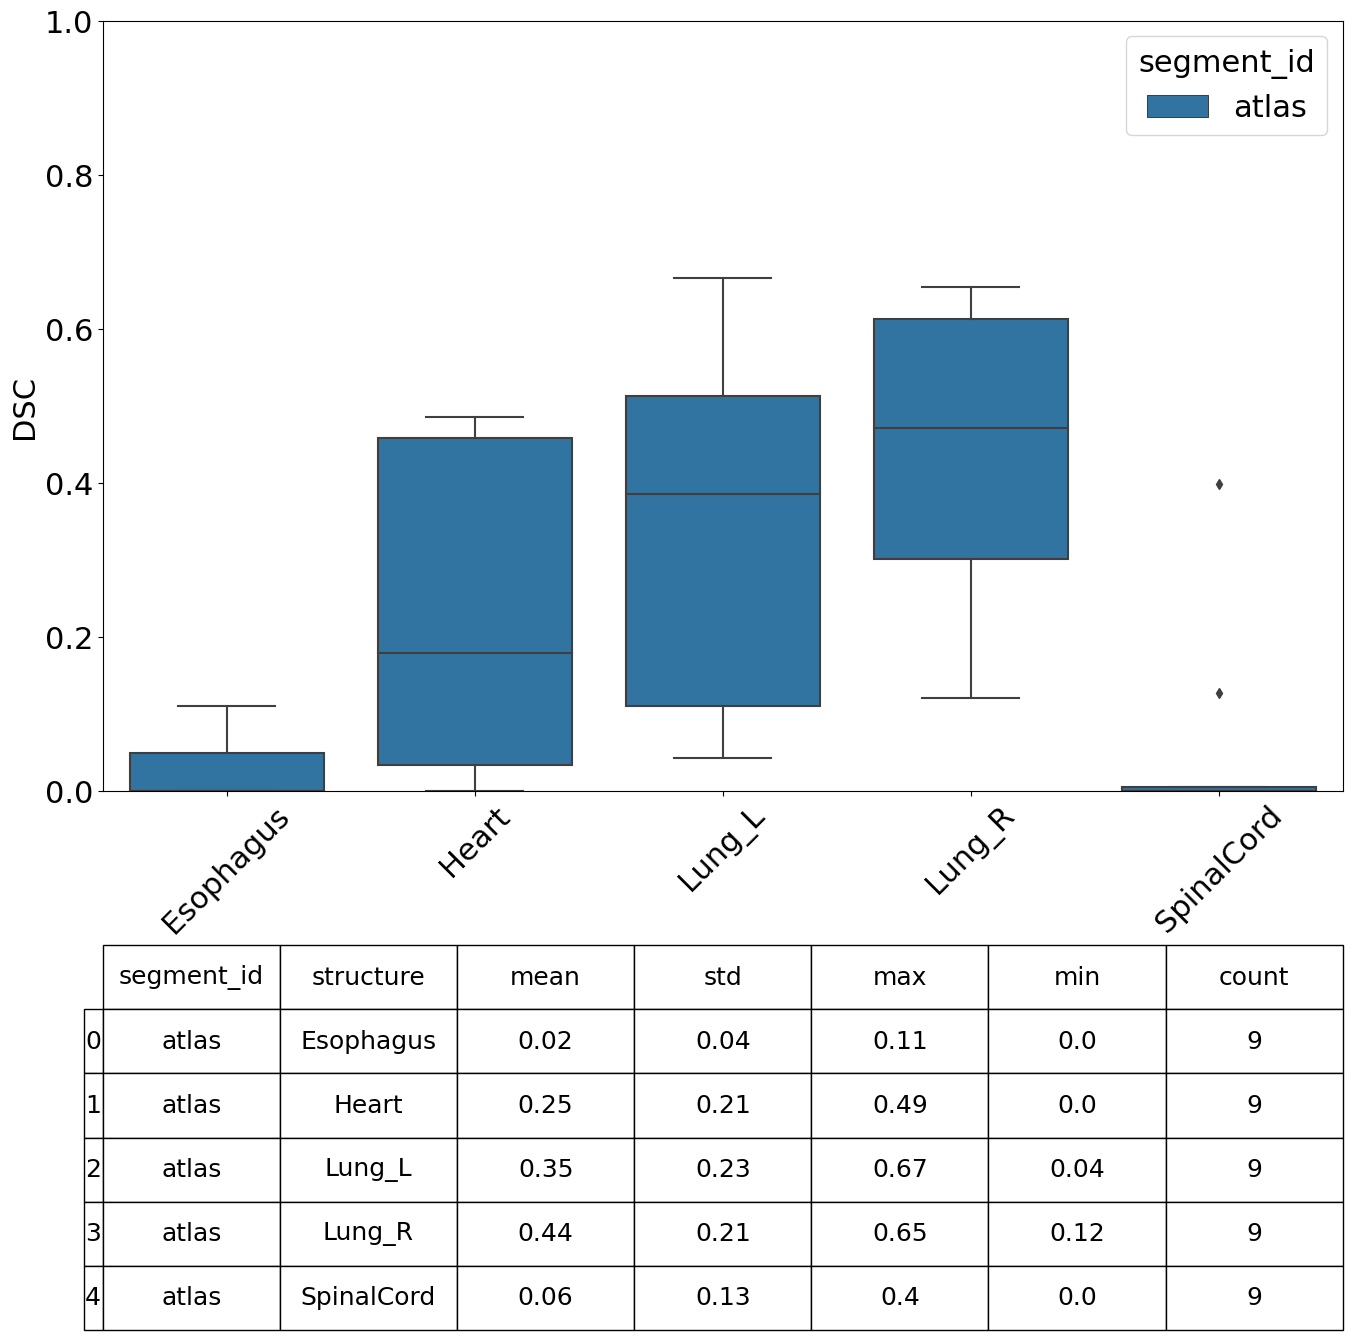

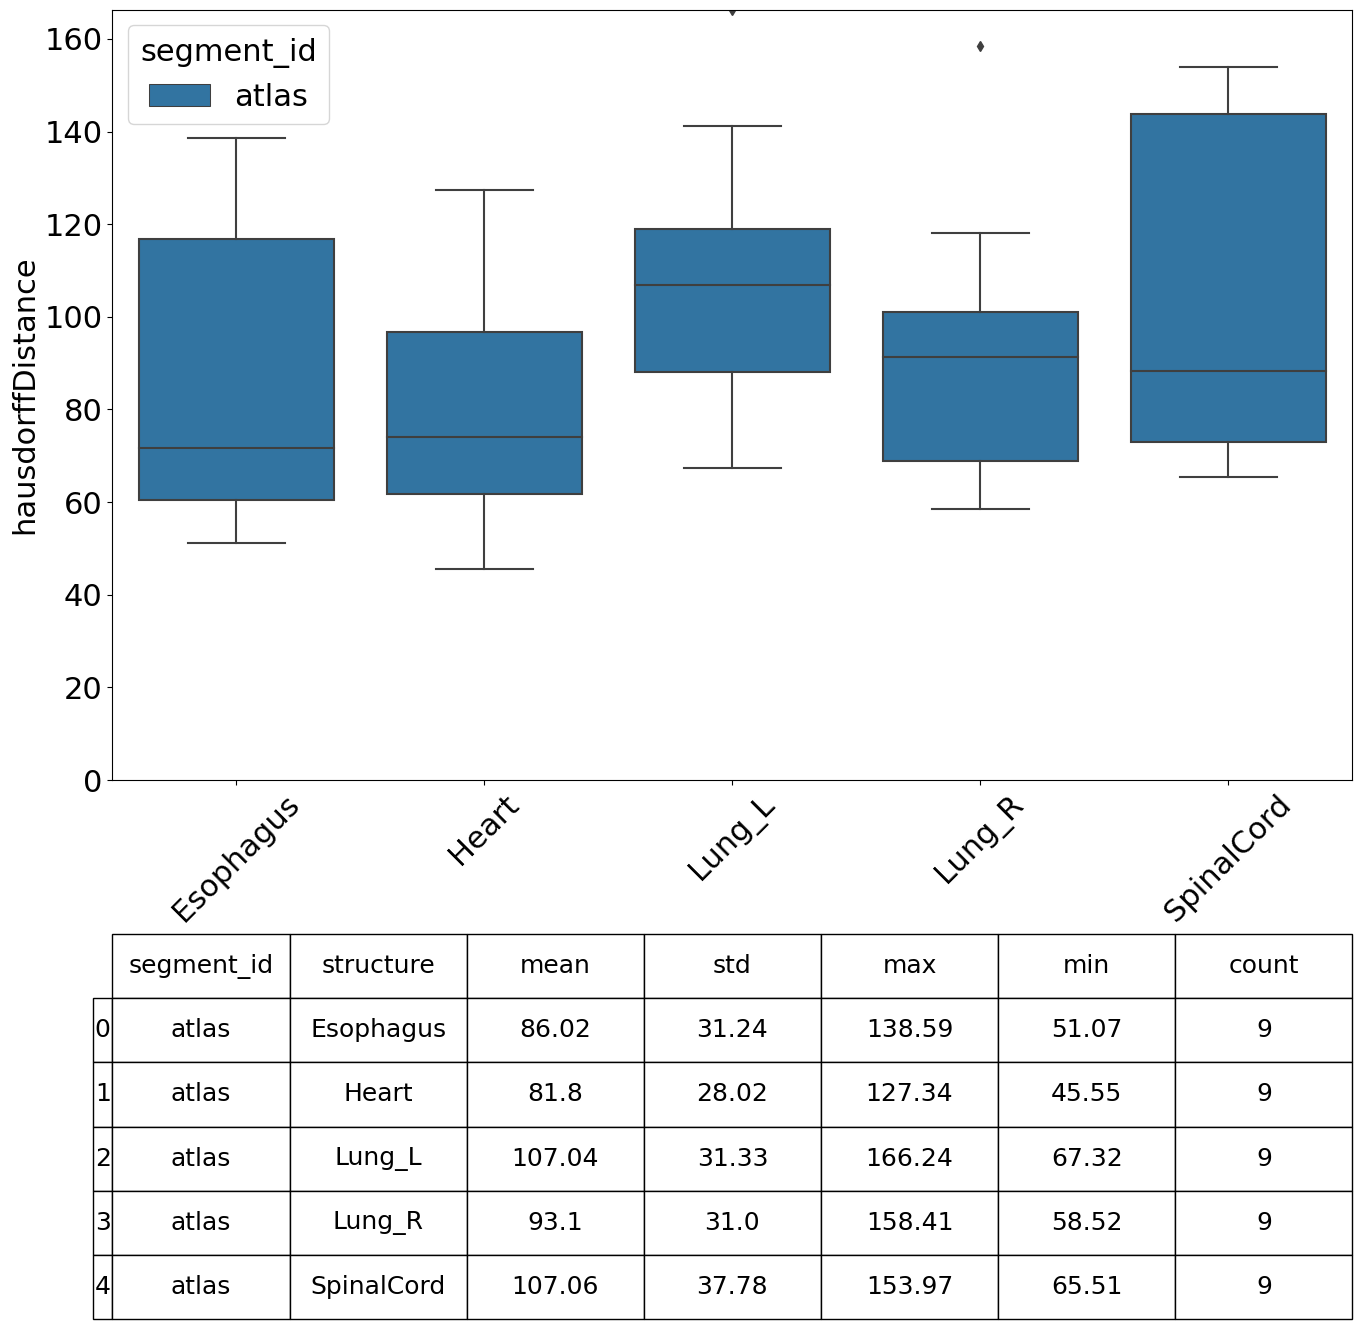

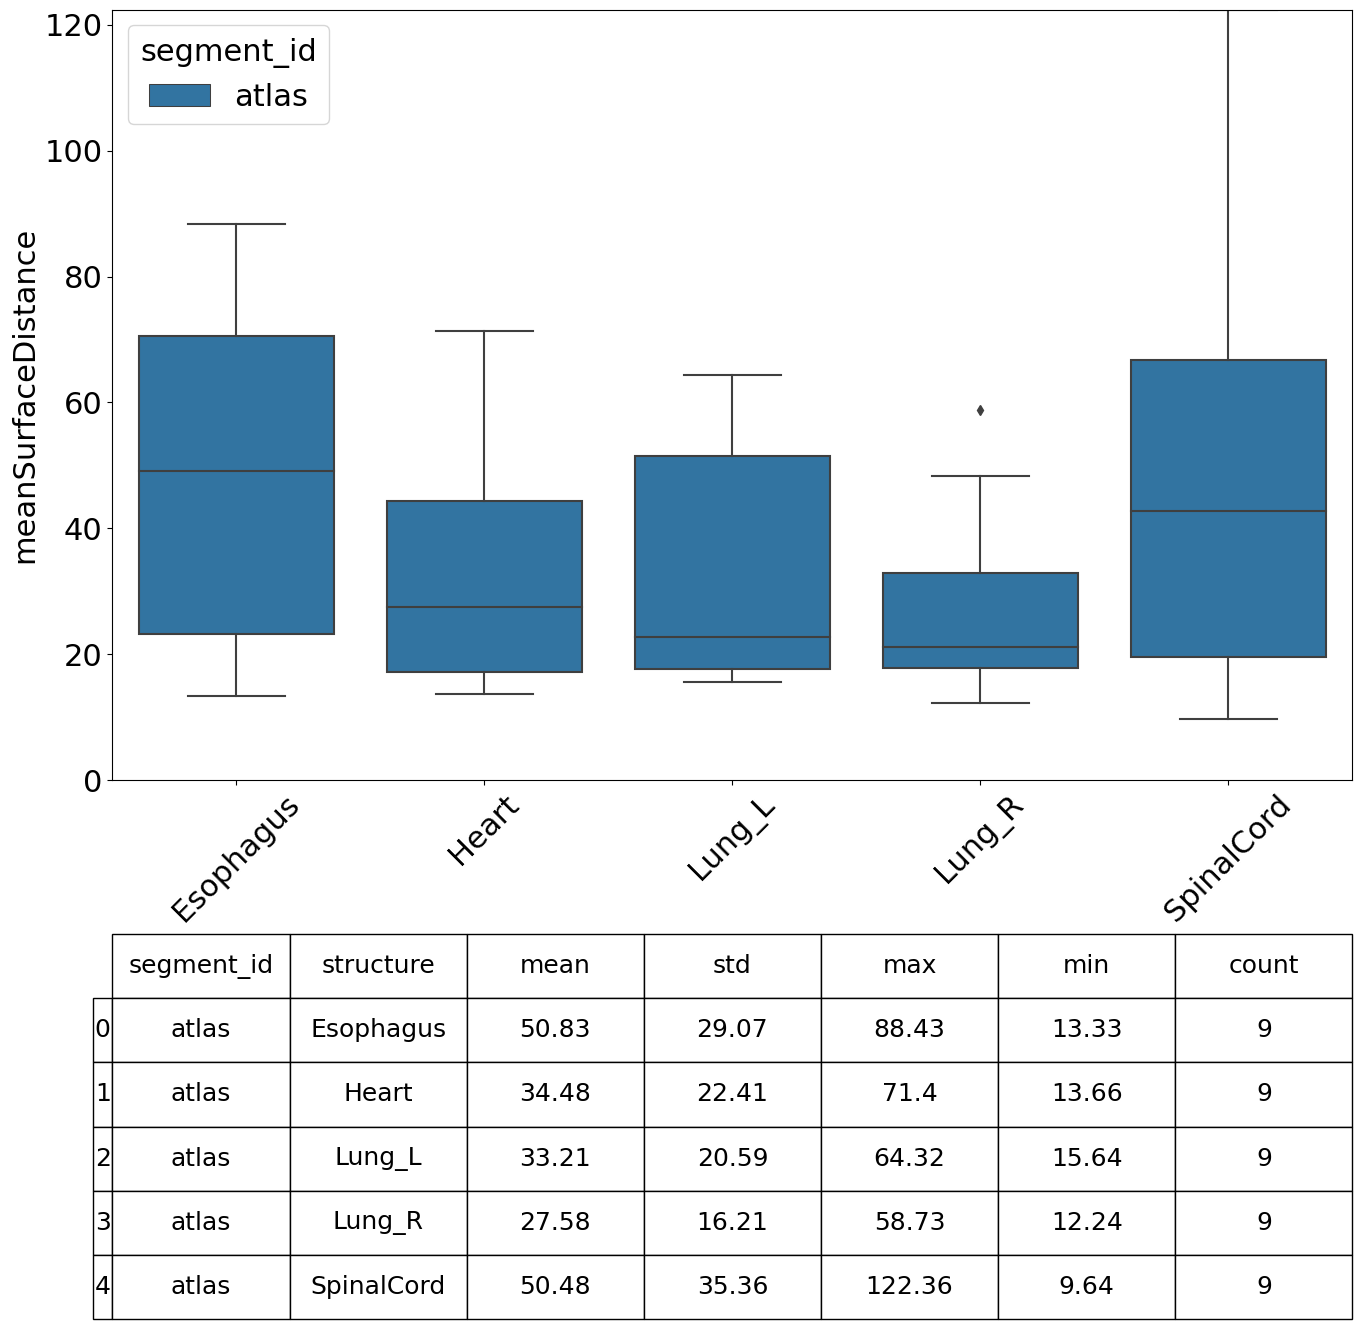

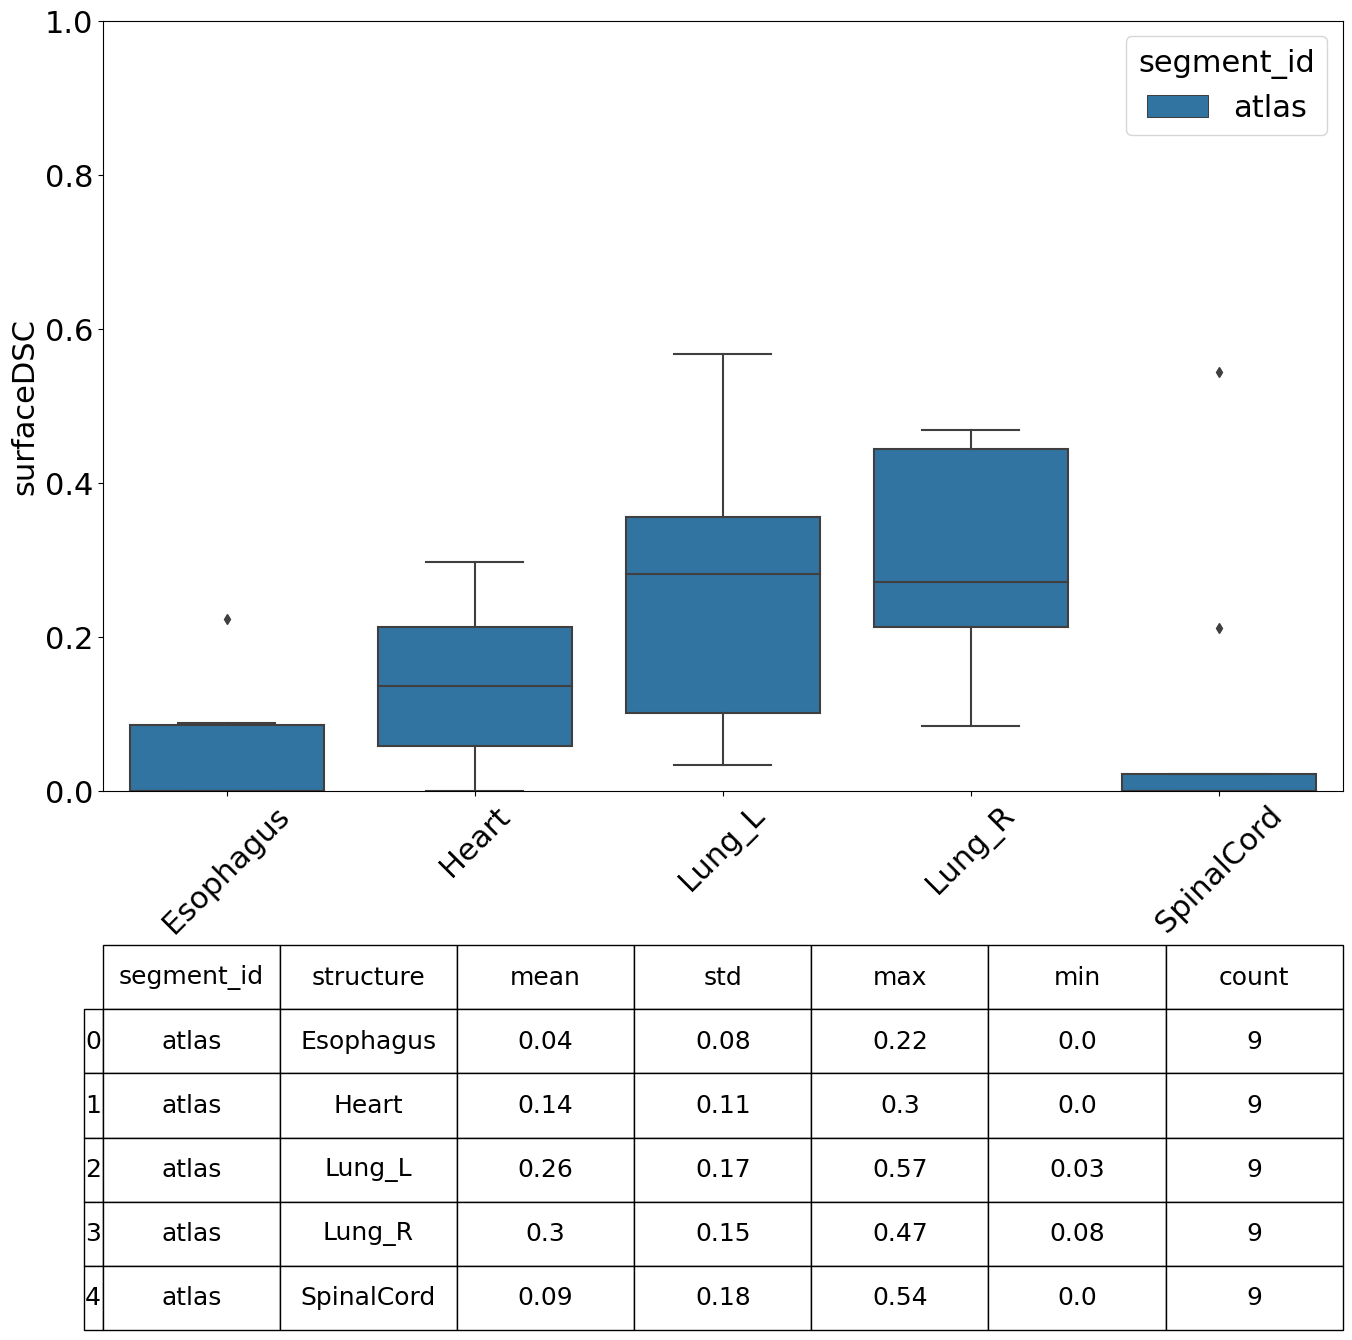

In [14]:
analysis_output_directory = working_directory.joinpath(
    "analysis",
    segment_id
)
analysis_output_directory.mkdir(parents=True, exist_ok=True)

prepare_similarity_metric_analysis(
    working_directory,
    analysis_output_directory=analysis_output_directory,
    dataset_name=validation_dataset,
    structure_mapping_id=mapping_id
)